In [1]:
import math
import xarray as xr
import cartopy.crs as crs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import numpy as np
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import datetime as dt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from netCDF4 import date2num,num2date
import wrf
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords
from wrf import getvar, xy, interp2dxy
from wrf import to_np, getvar, CoordPair, vertcross
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)

In [2]:
#CURRENT DATA
cur_wrfout6 = Dataset('CUR_wrfout_d03_2018-03-25_06_00_00')

cur_wrfout10 = Dataset('CUR_wrfout_d03_2018-03-25_10_00_00')
cur_wrfout11= Dataset('CUR_wrfout_d03_2018-03-25_11_00_00')
cur_wrfout12 = Dataset('CUR_wrfout_d03_2018-03-25_12_00_00')
cur_wrfout13= Dataset('CUR_wrfout_d03_2018-03-25_13_00_00')


In [3]:
#SST DATA
sst_wrfout6 = Dataset('SST_wrfout_d03_2018-03-25_06_00_00')

sst_wrfout10 = Dataset('SST_wrfout_d03_2018-03-25_10_00_00')
sst_wrfout11 = Dataset('SST_wrfout_d03_2018-03-25_11_00_00')
sst_wrfout12 = Dataset('SST_wrfout_d03_2018-03-25_12_00_00')
sst_wrfout13 = Dataset('SST_wrfout_d03_2018-03-25_13_00_00')


In [10]:
#print(sst_wrfout10.variables)

In [4]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)

#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [5]:
#Open HYCOM 25
ds_25 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_084_*_3z.nc')#, combine = 'by_coords', concat_dim = 'time')
ds_25.to_netcdf('test_25.nc')
ds25 = xr.open_dataset('test_25.nc')

#WRFIN_D03
wrfinput_d03 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/wrfinput_d03')

In [6]:
old_d03_SST = wrfinput_d03.SST.values-273.15
old_d03_UOCE = wrfinput_d03.UOCE.values
old_d03_VOCE = wrfinput_d03.VOCE.values
XLAT = wrfinput_d03.XLAT.values
XLON = wrfinput_d03.XLONG.values

print('XLAT: ', XLAT.shape, '\nXLON: ', XLON.shape )
print('Max lat: ', np.max(XLAT), '\Min lat: ', np.min(XLAT))
print('Max lon: ', np.max(XLON), '\Min lon: ', np.min(XLON))
print ('d03_UOCE: ',old_d03_UOCE.shape, '\nd03_VOCE: ',  old_d03_VOCE.shape, '\nd03_SST: ', old_d03_SST.shape)

print('\n\n LAT: ', XLAT)
print('\n\n LON: ', XLON)

#REAL RUN 
latbounds = [24, 29]
lonbounds = [-95, -87]

lats = ds25.Latitude.values[:]
lons = ds25.Longitude.values[:]

#set upper & lower bounds
latli = np.argmin(np.abs(lats-latbounds[0]))
latui = np.argmin(np.abs(lats-latbounds[1]))
lonli = np.argmin(np.abs(lons-lonbounds[0]))
lonui = np.argmin(np.abs(lons-lonbounds[1]))

lat_array=ds25.Latitude.values[latli:latui]
lon_array=ds25.Longitude.values[lonli:lonui]
u_subset_25=ds25.variables['u'][:,0,latli:latui, lonli:lonui]
meanU_25 = u_subset_25.mean('MT')
#meanU_25=meanU_25*0.54 - 0.19
meanU_25=meanU_25*0.75-0.15

#v current
v_subset_25=ds25.variables['v'][:,0,latli:latui, lonli:lonui]
meanV_25 = v_subset_25.mean('MT')
meanV_25=meanV_25*0.27+0.78
#meanV_25=meanV_25

#SST
SST_subset_25=ds25.variables['water_temp'][:,0,latli:latui, lonli:lonui]
meanSST_25 = SST_subset_25.mean('MT')

XLAT:  (1, 474, 639) 
XLON:  (1, 474, 639)
Max lat:  28.640232 \Min lat:  24.351265
Max lon:  -86.96835 \Min lon:  -93.500946
d03_UOCE:  (1, 474, 639) 
d03_VOCE:  (1, 474, 639) 
d03_SST:  (1, 474, 639)


 LAT:  [[[24.351944 24.352158 24.352379 ... 24.351715 24.351501 24.351265]
  [24.360924 24.361137 24.361351 ... 24.360687 24.360466 24.360252]
  [24.369919 24.370125 24.370338 ... 24.369705 24.369476 24.369255]
  ...
  [28.586124 28.586365 28.58659  ... 28.585907 28.585674 28.58545 ]
  [28.595127 28.59534  28.59557  ... 28.594894 28.594662 28.594429]
  [28.604115 28.604328 28.604568 ... 28.603882 28.603653 28.60342 ]]]


 LON:  [[[-93.38281  -93.372955 -93.3631   ... -87.10733  -87.09747  -87.087585]
  [-93.38306  -93.37317  -93.36334  ... -87.107086 -87.09723  -87.08734 ]
  [-93.3833   -93.37341  -93.363556 ... -87.10684  -87.096985 -87.08713 ]
  ...
  [-93.50043  -93.490204 -93.47995  ... -86.98935  -86.979126 -86.96887 ]
  [-93.50067  -93.49045  -93.480225 ... -86.989075 -86.97885  

In [7]:
#March 25 Dopplerscat
ds25_5 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0326-0368_line05.L2.nc')
ds25_6 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0380-0436_line06.L2.nc')
ds25_7 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0450-0490_line07.L2.nc')


In [8]:
#set other DS variables 
lat25_5=ds25_5.latitude.values
lon25_5=ds25_5.longitude.values
flag25_5=ds25_5.flag.values
u_cur25_5=ds25_5.u_current.values

lat25_6=ds25_6.latitude.values
lon25_6=ds25_6.longitude.values
flag25_6=ds25_6.flag.values
u_cur25_6=ds25_6.u_current.values

lat25_7=ds25_7.latitude.values
lon25_7=ds25_7.longitude.values
flag25_7=ds25_7.flag.values
u_cur25_7=ds25_7.u_current.values

#v current
v_cur25_5=ds25_5.v_current.values
v_cur25_6=ds25_6.v_current.values
v_cur25_7=ds25_7.v_current.values


In [9]:
#Apply Error Flag 
#0 is good, 2 is bad
#set flag to only accept 0
   
lonlen25_5=len(lon25_5)
latlen25_5=len(lat25_5)
goodUarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodUarr25_5[:]=np.nan
goodVarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodVarr25_5[:]=np.nan
for x in range (len(lon25_5)):
    for y in range (len(lat25_5)):
        if flag25_5[y,x] == 0:
            goodUarr25_5[y,x] = u_cur25_5[y,x] 
            goodVarr25_5[y,x] = v_cur25_5[y,x] 
            
lonlen25_6=len(lon25_6)
latlen25_6=len(lat25_6)
goodUarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodUarr25_6[:]=np.nan
goodVarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodVarr25_6[:]=np.nan
for x in range (len(lon25_6)):
    for y in range (len(lat25_6)):
        if flag25_6[y,x] == 0:
            goodUarr25_6[y,x] = u_cur25_6[y,x] 
            goodVarr25_6[y,x] = v_cur25_6[y,x] 
            
lonlen25_7=len(lon25_7)
latlen25_7=len(lat25_7)
goodUarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodUarr25_7[:]=np.nan
goodVarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodVarr25_7[:]=np.nan
for x in range (len(lon25_7)):
    for y in range (len(lat25_7)):
        if flag25_7[y,x] == 0:
            goodUarr25_7[y,x] = u_cur25_7[y,x] 
            goodVarr25_7[y,x] = v_cur25_7[y,x] 


In [10]:
#Gaussian Filter U25
HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)


#make current arrays (u & v) that match lat & lon dimensions, fill with nans 
u25_WRF  = np.zeros((WRF_latLen, WRF_lonLen))   
u25_WRF[:] = -999
DS_weightedU25 = u25_WRF*0
HYCOM_weightedU25 = u25_WRF*0

#at equator, 1deg = 111.31949077920639km, so 1km*(1deg/111.31949077920639km) = 0.00898315
#Great Circle Calculator 
#http://edwilliams.org/gccalc.htm

km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS

for y in range (0, WRF_latLen):  
#for y in range (0, len(WRF_lat)):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
    #for x in range (0, len(WRF_lon)):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_u25HYCOM = 0

        sum_weight_DS25u5 = 0
        sum_product_u25DS5 = 0
        sum_weight_DS25u6 = 0
        sum_product_u25DS6 = 0
        sum_weight_DS25u7 = 0
        sum_product_u25DS7 = 0
       
        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])  

        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25u5_test1_In = np.where(lon25_5 >= min_lon)
        DS25u5_test2_In = np.where(lon25_5 <= max_lon)
        DS25u5_inter_like_lon = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In)
        DS25u5_test1_In = np.where(lat25_5 >= min_lat)
        DS25u5_test2_In = np.where(lat25_5 <= max_lat)
        DS25u5_inter_like_lat = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In) 
        
        DS25u6_test1_In = np.where(lon25_6 >= min_lon)
        DS25u6_test2_In = np.where(lon25_6 <= max_lon)
        DS25u6_inter_like_lon = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In)
        DS25u6_test1_In = np.where(lat25_6 >= min_lat)
        DS25u6_test2_In = np.where(lat25_6 <= max_lat)
        DS25u6_inter_like_lat = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In) 

        DS25u7_test1_In = np.where(lon25_7 >= min_lon)
        DS25u7_test2_In = np.where(lon25_7 <= max_lon)
        DS25u7_inter_like_lon = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)
        DS25u7_test1_In = np.where(lat25_7 >= min_lat)
        DS25u7_test2_In = np.where(lat25_7 <= max_lat)
        DS25u7_inter_like_lat = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)

        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index     
        DS25u5_lon_indices =  DS25u5_inter_like_lon
        DS25u5_lat_indices =  DS25u5_inter_like_lat
        DS25u6_lon_indices =  DS25u6_inter_like_lon
        DS25u6_lat_indices =  DS25u6_inter_like_lat
        DS25u7_lon_indices =  DS25u7_inter_like_lon
        DS25u7_lat_indices =  DS25u7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25u5_good_lon = lon25_5[DS25u5_lon_indices]
        DS25u5_good_lat = lat25_5[DS25u5_lat_indices] 
        DS25u6_good_lon = lon25_6[DS25u6_lon_indices]
        DS25u6_good_lat = lat25_6[DS25u6_lat_indices] 
        DS25u7_good_lon = lon25_7[DS25u7_lon_indices]
        DS25u7_good_lat = lat25_7[DS25u7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25u5_good_lon_len = len(DS25u5_good_lon)
        DS25u5_good_lat_len = len(DS25u5_good_lat) 
        DS25u6_good_lon_len = len(DS25u6_good_lon)
        DS25u6_good_lat_len = len(DS25u6_good_lat)  
        DS25u7_good_lon_len = len(DS25u7_good_lon)
        DS25u7_good_lat_len = len(DS25u7_good_lat)      
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                #if distance <= 3 * sigma_HYCOM: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    #weight_HYCOM = 0.2*(1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_u25HYCOM = sum_product_u25HYCOM + weight_HYCOM * meanU_25[lat_indices[y_small], lon_indices[x_small]]
                #print('sum product HYCOM', sum_product_u25HYCOM)
                HYCOM_weightedU25[y,x] =  (sum_product_u25HYCOM/sum_weight_HYCOM)
        #print('sum product HYCOM', sum_product_u25HYCOM)
        #loop through values of good DS arrays 
         
        for y_small_DS25u5 in range(0, DS25u5_good_lat_len):
            for x_small_DS25u5 in range(0, DS25u5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u5_good_lat[y_small_DS25u5]-WRF_lat[y])**2+((DS25u5_good_lon[x_small_DS25u5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]): 
                    weight_DS25u5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u5 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u5 = sum_weight_DS25u5 + weight_DS25u5
                    sum_product_u25DS5 = sum_product_u25DS5 + weight_DS25u5 * goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]
                    #print('sum_product_u25DS5: ', sum_product_u25DS5)
                else: 
                    weight_DS25u5 = 0 
                    
        for y_small_DS25u6 in range(0, DS25u6_good_lat_len):
            for x_small_DS25u6 in range(0, DS25u6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25u6_good_lat[y_small_DS25u6]-WRF_lat[y])**2+((DS25u6_good_lon[x_small_DS25u6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]): 
                    weight_DS25u6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u6 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u6 = sum_weight_DS25u6 + weight_DS25u6
                    sum_product_u25DS6 = sum_product_u25DS6 + weight_DS25u6 * goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]
                else: 
                    weight_DS25u6 = 0 
                    
        for y_small_DS25u7 in range(0, DS25u7_good_lat_len):
            for x_small_DS25u7 in range(0, DS25u7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u7_good_lat[y_small_DS25u7]-WRF_lat[y])**2+((DS25u7_good_lon[x_small_DS25u7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]): 
                    weight_DS25u7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u7 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u7 = sum_weight_DS25u7 + weight_DS25u7
                    sum_product_u25DS7 = sum_product_u25DS7 + weight_DS25u7 * goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]
                else: 
                    weight_DS25u7 = 0 
        #print('sum_product_DS: ', sum_product_u25DS5+sum_product_u25DS6+ sum_product_u25DS7)
            
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedU25[y,x] =  (sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/ DS_weight 
        else: 
            DS_weightedU25[y,x] = -999
            
        u25_WRF[y,x] = (sum_product_u25HYCOM + sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/(sum_weight_HYCOM + sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth 


In [11]:
print(u25_WRF.shape) #<---- this the the UOCE for WRF 
print(WRF_lon.shape)
print(WRF_lat.shape)
print(u25_WRF)
print(DS_weightedU25.shape)
print(HYCOM_weightedU25.shape)

for x in u25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in u25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')

(474, 639)
(639,)
(474,)
[[-0.03676818 -0.03676818 -0.03462522 ... -0.39933854 -0.39933854
  -0.39933854]
 [-0.03676818 -0.03574877 -0.03462471 ... -0.40015855 -0.39933854
  -0.39933854]
 [-0.03759319 -0.0365577  -0.03541112 ... -0.39922357 -0.39837169
  -0.39933854]
 ...
 [-0.05680274 -0.05675372 -0.05664098 ... -0.01681774 -0.01658411
  -0.01658411]
 [-0.05700583 -0.05694038 -0.05687633 ... -0.01609657 -0.01579646
  -0.01508605]
 [-0.057189   -0.05710773 -0.05702867 ... -0.01545005 -0.01508605
  -0.01508605]]
(474, 639)
(474, 639)


In [12]:
#Gaussian Filter V25
#HYCOM: lat_array (Y), lon_array (X), meanU_25
#DS: goodUarr25_1-10, lat25_1, lon25_1s

HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)

v25_WRF = np.zeros((WRF_latLen, WRF_lonLen))  
#u25_WRF[:] = -999
v25_WRF[:] = -999

DS_weightedV25 = v25_WRF*0
HYCOM_weightedV25= v25_WRF*0

#DS sigma??? = 0.03 # 0.015*2   
km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS


for y in range (0, WRF_latLen):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_v25HYCOM = 0

        sum_weight_DS25v5 = 0
        sum_product_v25DS5 = 0
        sum_weight_DS25v6 = 0
        sum_product_v25DS6 = 0
        sum_weight_DS25v7 = 0
        sum_product_v25DS7 = 0

        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])   
        
        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25v5_test1_In = np.where(lon25_5 >= min_lon)
        DS25v5_test2_In = np.where(lon25_5 <= max_lon)
        DS25v5_inter_like_lon = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In)
        DS25v5_test1_In = np.where(lat25_5 >= min_lat)
        DS25v5_test2_In = np.where(lat25_5 <= max_lat)
        DS25v5_inter_like_lat = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In) 
        
        DS25v6_test1_In = np.where(lon25_6 >= min_lon)
        DS25v6_test2_In = np.where(lon25_6 <= max_lon)
        DS25v6_inter_like_lon = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In)
        DS25v6_test1_In = np.where(lat25_6 >= min_lat)
        DS25v6_test2_In = np.where(lat25_6 <= max_lat)
        DS25v6_inter_like_lat = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In) 

        DS25v7_test1_In = np.where(lon25_7 >= min_lon)
        DS25v7_test2_In = np.where(lon25_7 <= max_lon)
        DS25v7_inter_like_lon = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)
        DS25v7_test1_In = np.where(lat25_7 >= min_lat)
        DS25v7_test2_In = np.where(lat25_7 <= max_lat)
        DS25v7_inter_like_lat = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)

        #np.where((HYCOM_lon >= min_lon) and (HYCOM_lon <= max_lon), HYCOM_lon)
        #np.where((HYCOM_lat >= min_lat) and (HYCOM_lat <= max_lat))
        
        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index       
        DS25v5_lon_indices =  DS25v5_inter_like_lon
        DS25v5_lat_indices =  DS25v5_inter_like_lat
        DS25v6_lon_indices =  DS25v6_inter_like_lon
        DS25v6_lat_indices =  DS25v6_inter_like_lat
        DS25v7_lon_indices =  DS25v7_inter_like_lon
        DS25v7_lat_indices =  DS25v7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25v5_good_lon = lon25_5[DS25v5_lon_indices]
        DS25v5_good_lat = lat25_5[DS25v5_lat_indices] 
        DS25v6_good_lon = lon25_6[DS25v6_lon_indices]
        DS25v6_good_lat = lat25_6[DS25v6_lat_indices] 
        DS25v7_good_lon = lon25_7[DS25v7_lon_indices]
        DS25v7_good_lat = lat25_7[DS25v7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25v5_good_lon_len = len(DS25v5_good_lon)
        DS25v5_good_lat_len = len(DS25v5_good_lat) 
        DS25v6_good_lon_len = len(DS25v6_good_lon)
        DS25v6_good_lat_len = len(DS25v6_good_lat)  
        DS25v7_good_lon_len = len(DS25v7_good_lon)
        DS25v7_good_lat_len = len(DS25v7_good_lat)     
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                #print('distance: ', distance)
                #print('3sigma', 3*sigma_HYCOM)
                #print(y, x, y_small, x_small, distance, good_lat[y_small], WRF_lat[y], good_lon[x_small], WRF_lon[x])
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM
                #print('sum_weight_HYCOM: ', sum_weight_HYCOM)

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_v25HYCOM = sum_product_v25HYCOM + weight_HYCOM * meanV_25[lat_indices[y_small], lon_indices[x_small]]
                HYCOM_weightedV25[y,x] =  sum_product_v25HYCOM/sum_weight_HYCOM

        for y_small_DS25v5 in range(0, DS25v5_good_lat_len):
            for x_small_DS25v5 in range(0, DS25v5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v5_good_lat[y_small_DS25v5]-WRF_lat[y])**2+((DS25v5_good_lon[x_small_DS25v5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]): 
                    weight_DS25v5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v5 = sum_weight_DS25v5 + weight_DS25v5
                    sum_product_v25DS5 = sum_product_v25DS5 + weight_DS25v5 * goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]
                else: 
                    weight_DS25v5 = 0 
                    
        for y_small_DS25v6 in range(0, DS25v6_good_lat_len):
            for x_small_DS25v6 in range(0, DS25v6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25v6_good_lat[y_small_DS25v6]-WRF_lat[y])**2+((DS25v6_good_lon[x_small_DS25v6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]): 
                    weight_DS25v6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v6 = sum_weight_DS25v6 + weight_DS25v6
                    sum_product_v25DS6 = sum_product_v25DS6 + weight_DS25v6 * goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]
                else: 
                    weight_DS25v6 = 0 
                    
        for y_small_DS25v7 in range(0, DS25v7_good_lat_len):
            for x_small_DS25v7 in range(0, DS25v7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v7_good_lat[y_small_DS25v7]-WRF_lat[y])**2+((DS25v7_good_lon[x_small_DS25v7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]): 
                    weight_DS25v7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v7 = sum_weight_DS25v7 + weight_DS25v7
                    sum_product_v25DS7 = sum_product_v25DS7 + weight_DS25v7 * goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]
                else: 
                    weight_DS25v7 = 0 
           
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedV25[y,x] =  (sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(DS_weight) #add each DS sum, add ech sum weigth 
        else: 
            DS_weightedV25[y,x] = -999
                     
        v25_WRF[y,x] = (sum_product_v25HYCOM + sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(sum_weight_HYCOM + sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth 


In [13]:
print(v25_WRF.shape)
print(WRF_lon.shape)
print(WRF_lat.shape)
print(v25_WRF)
print(DS_weightedV25.shape)
print(HYCOM_weightedV25.shape)

for x in v25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in v25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')  
print('sigma DS:', sigma_DS)
print('sigma HYCOM', sigma_HYCOM)

(474, 639)
(639,)
(474,)
[[0.86421758 0.86421758 0.86442354 ... 0.94721484 0.94721484 0.94721484]
 [0.86421758 0.86431556 0.86442359 ... 0.94785106 0.94721484 0.94721484]
 [0.86413716 0.86423675 0.86434702 ... 0.94774068 0.94711906 0.94721484]
 ...
 [0.80682278 0.80683526 0.80685814 ... 0.86809943 0.86792558 0.86792558]
 [0.80677201 0.80678861 0.80680485 ... 0.86801113 0.86782245 0.86772943]
 [0.80672622 0.80674678 0.80676678 ... 0.86793198 0.86772943 0.86772943]]
(474, 639)
(474, 639)
sigma DS: 1.0
sigma HYCOM 0.02


In [14]:
#Vorticity ----> WRF currents vorticity
Y = WRF_lat #474
X = WRF_lon #613
U =  u25_WRF #474, 613
V =  v25_WRF #474, 613
print('X: ', X.shape)
print('Y: ', Y.shape)
print('U: ', U.shape)
print('V: ', V.shape)

#metpy vort
#Vorticity=curl
dxdy=mpcalc.lat_lon_grid_deltas(longitude=WRF_lon, latitude=WRF_lat, x_dim=- 1, y_dim=- 2, geod=None)
#print(dxdy.shape)
#print(dxdy)

#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
mp_curl=mpcalc.vorticity(u=u25_WRF*units('m/s'), v=v25_WRF*units('m/s'), dx=dxdy[0], dy=dxdy[1])


X:  (639,)
Y:  (474,)
U:  (474, 639)
V:  (474, 639)


C:\Users\Anna\anaconda3\envs\metpy\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


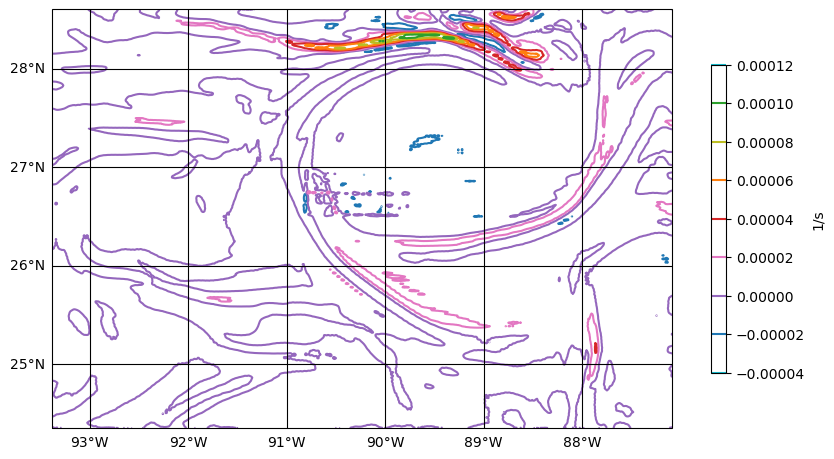

In [15]:
#metpy curl plot 
Y = WRF_lat
X = WRF_lon
U =  u25_WRF
V =  v25_WRF

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

lon2D, lat2D = np.meshgrid(X, Y)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#ax.set_extent([-90.9, -89.65, 26.45, 27.15], crs=mapcrs)
ax.coastlines()

cs = ax.contour(X, Y, mp_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()


In [16]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)

#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [18]:

S_U= []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(U[y][x])
    S_U.append(inner_arr)
S_U = np.array(S_U)
print('S_U shape: ', S_U.shape)

N_U= []
for y in lat_int_north:
    inner_arr2 = []
    for x in lon_int_north:
        inner_arr2.append(U[y][x])
    N_U.append(inner_arr2)
N_U = np.array(N_U) 
print('N_U shape: ', N_U.shape)

S_V= []
for y in lat_int_south:
    inner_arr3 = []
    for x in lon_int_south:
        inner_arr3.append(V[y][x])
    S_V.append(inner_arr3)
S_V = np.array(S_V)
print('S_V shape: ', S_V.shape)

N_V= []
for y in lat_int_north:
    inner_arr4 = []
    for x in lon_int_north:
        inner_arr4.append(V[y][x])
    N_V.append(inner_arr4)
N_V = np.array(N_V) 
print('N_V shape: ', N_V.shape)

S_U shape:  (67, 118)
N_U shape:  (67, 167)
S_V shape:  (67, 118)
N_V shape:  (67, 167)


In [19]:
X= np.array(north_lon)
Y= np.array(north_lat)
#U=N_U
#V=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X, latitude=Y, x_dim=- 1, y_dim=- 2, geod=None)
 
N_curl=mpcalc.vorticity(u=N_U*units('m/s'), v=N_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(N_curl)

[[6.0438661694226e-06 5.4839157263247395e-06 4.337422843672141e-06 ...  -1.3130351088453426e-05 -1.339964972999028e-05 -1.1906327183874941e-05] [8.456424770323043e-06 8.386938342410362e-06 7.083131685377229e-06 ...  -1.3836817165353485e-05 -1.3349044470078346e-05 -1.2682185872483988e-05] [1.0725978828764857e-05 1.0638568722113202e-05 9.40148647724148e-06 ...  -1.4380345837226188e-05 -1.3526257418534492e-05 -1.2272570620031336e-05] ... [-1.5623052149268982e-05 -1.58956604641503e-05 -1.662372085340354e-05  ... 4.666813239488875e-05 4.670134823793503e-05 4.738935294405608e-05] [-1.5946385329362954e-05 -1.6182185528596394e-05 -1.675986950177598e-05  ... 3.720178226394931e-05 3.661441746119483e-05 3.660824482204263e-05] [-1.4277565148521364e-05 -1.6195794264660352e-05 -1.6150997518188154e-05  ... 2.9776675463971615e-05 3.0107353235049204e-05 2.354627547865876e-05]] / second


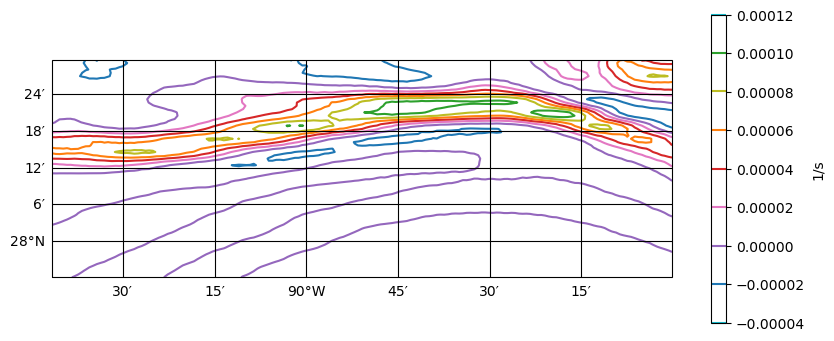

In [20]:

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()

In [21]:
X2= np.array(south_lon)
Y2= np.array(south_lat)
#U2=N_U
#V2=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X2, latitude=Y2, x_dim=- 1, y_dim=- 2, geod=None)
 
S_curl=mpcalc.vorticity(u=S_U*units('m/s'), v=S_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(S_curl)

[[-1.1356667272870751e-05 -1.1242816221363723e-05 -6.928646623509341e-06  ... 9.427031521394439e-06 9.069987097998775e-06 8.754240009654435e-06] [-8.992385778808758e-06 -5.4688753835724965e-06 -6.138354801861083e-07  ... 8.87014676660675e-06 8.863800220135774e-06 8.504148854027193e-06] [-5.154055347921442e-06 -2.2010937545630473e-07 4.8039228708998455e-06  ... 9.034483209232713e-06 8.879974253863667e-06 8.875936729634112e-06] ... [-2.175676583582634e-05 -2.098573306808264e-05 -1.9732313492456827e-05  ... -1.3536393756093026e-05 -1.3200959035693845e-05  -1.3118424623483624e-05] [-2.0243701862002195e-05 -2.0022253933831935e-05 -1.918433741922369e-05  ... -1.2853959646554286e-05 -1.2722557453745495e-05  -1.2266396242174577e-05] [-1.596932362861838e-05 -1.8360756755333996e-05 -1.919440166976694e-05  ... -1.310219571807968e-05 -1.280638306683468e-05 -1.25642136893703e-05]] / second


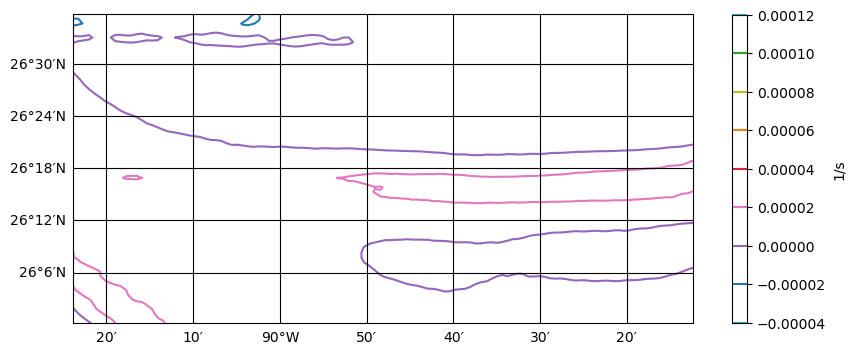

In [22]:
bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

#lon2D, lat2D = np.meshgrid(X2, Y2)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
#plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False
#plt.title('Current Speed (Vector in m/s)\n& Curl (Contour in 1/s)')
#save_results_to = '/Users/Anna/Desktop/WRF/'
#plt.savefig(save_results_to + '25_Vectors.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [23]:
#Get PBLH
#Not staggered
'''
cur_pblh_10 = getvar(cur_wrfout10, "PBLH")
cur_pblh_11 = getvar(cur_wrfout11, "PBLH")
cur_pblh_12 = getvar(cur_wrfout12, "PBLH")
cur_pblh_13 = getvar(cur_wrfout13, "PBLH")

sst_pblh_10 = getvar(sst_wrfout10, "PBLH")
sst_pblh_11 = getvar(sst_wrfout11, "PBLH")
sst_pblh_12 = getvar(sst_wrfout12, "PBLH")
sst_pblh_13 = getvar(sst_wrfout13, "PBLH")

#Get U
cur_U_10 = getvar(cur_wrfout10, "U")
cur_U_11 = getvar(cur_wrfout11, "U")
cur_U_12 = getvar(cur_wrfout12, "U")
cur_U_13 = getvar(cur_wrfout13, "U")
cur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)
cur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)
cur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)
cur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)

cur_U10_10 = getvar(cur_wrfout10, "U10")
cur_U10_11 = getvar(cur_wrfout11, "U10")
cur_U10_12 = getvar(cur_wrfout12, "U10")
cur_U10_13 = getvar(cur_wrfout13, "U10")

sst_U_10 = getvar(sst_wrfout10, "U")
sst_U_11 = getvar(sst_wrfout11, "U")
sst_U_12 = getvar(sst_wrfout12, "U")
sst_U_13 = getvar(sst_wrfout13, "U")
sst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)
sst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)
sst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)
sst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)

sst_U10_10 = getvar(sst_wrfout10, "U10")
sst_U10_11 = getvar(sst_wrfout11, "U10")
sst_U10_12 = getvar(sst_wrfout12, "U10")
sst_U10_13 = getvar(sst_wrfout13, "U10")

cur_V_10 = getvar(cur_wrfout10, "V")
cur_V_11 = getvar(cur_wrfout11, "V")
cur_V_12 = getvar(cur_wrfout12, "V")
cur_V_13 = getvar(cur_wrfout13, "V")
cur_V_10 = wrf.destagger(cur_V_10, stagger_dim = 1)
cur_V_11  = wrf.destagger(cur_V_11, stagger_dim = 1)
cur_V_12 = wrf.destagger(cur_V_12, stagger_dim = 1)
cur_V_13  = wrf.destagger(cur_V_13, stagger_dim = 1)

cur_V10_10 = getvar(cur_wrfout10, "V10")
cur_V10_11 = getvar(cur_wrfout11, "V10")
cur_V10_12 = getvar(cur_wrfout12, "V10")
cur_V10_13 = getvar(cur_wrfout13, "V10")

sst_V_10 = getvar(sst_wrfout10, "V")
sst_V_11 = getvar(sst_wrfout11, "V")
sst_V_12 = getvar(sst_wrfout12, "V")
sst_V_13 = getvar(sst_wrfout13, "V")
sst_V_10 = wrf.destagger(sst_V_10, stagger_dim = 1)
sst_V_11  = wrf.destagger(sst_V_11, stagger_dim = 1)
sst_V_12 = wrf.destagger(sst_V_12, stagger_dim = 1)
sst_V_13  = wrf.destagger(sst_V_13, stagger_dim = 1)

sst_V10_10 = getvar(sst_wrfout10, "V10")
sst_V10_11 = getvar(sst_wrfout11, "V10")
sst_V10_12 = getvar(sst_wrfout12, "V10")
sst_V10_13 = getvar(sst_wrfout13, "V10")

#potential temp. perturbation
sst_pertT10 =getvar(sst_wrfout10, 'T')
sst_pertT11 =getvar(sst_wrfout11, 'T')
sst_pertT12 =getvar(sst_wrfout12, 'T')
sst_pertT13 =getvar(sst_wrfout13, 'T')

cur_pertT10 =getvar(cur_wrfout10, 'T')
cur_pertT11 =getvar(cur_wrfout11, 'T')
cur_pertT12 =getvar(cur_wrfout12, 'T')
cur_pertT13 =getvar(cur_wrfout13, 'T')

#reference temperature 
sst_refT10 =getvar(sst_wrfout10, 'T00')
sst_refT11 =getvar(sst_wrfout11, 'T00')
sst_refT12 =getvar(sst_wrfout12, 'T00')
sst_refT13 =getvar(sst_wrfout13, 'T00')

cur_refT10 =getvar(cur_wrfout10, 'T00')
cur_refT11 =getvar(cur_wrfout11, 'T00')
cur_refT12 =getvar(cur_wrfout12, 'T00')
cur_refT13 =getvar(cur_wrfout13, 'T00')

#THETA
#theta = potentional temp. perturbation + reference temp
sst_theta10 = sst_pertT10 + sst_refT10
sst_theta11 = sst_pertT11 + sst_refT11
sst_theta12 = sst_pertT12 + sst_refT12
sst_theta13 = sst_pertT13 + sst_refT13

cur_theta10 = cur_pertT10 + cur_refT10
cur_theta11 = cur_pertT11 + cur_refT11
cur_theta12 = cur_pertT12 + cur_refT12
cur_theta13 = cur_pertT13 + cur_refT13
'''
#EMISS
emis_sst10 = getvar(sst_wrfout10, 'EMISS')
emis_sst11 = getvar(sst_wrfout11, 'EMISS')
emis_sst12 = getvar(sst_wrfout12, 'EMISS')
emis_sst13 = getvar(sst_wrfout13, 'EMISS')

emis_cur10 = getvar(cur_wrfout10, 'EMISS')
emis_cur11 = getvar(cur_wrfout10, 'EMISS')
emis_cur12 = getvar(cur_wrfout10, 'EMISS')
emis_cur13 = getvar(cur_wrfout10, 'EMISS')

#SST_INPUT
skin_sst10 = getvar(sst_wrfout10, 'SST_INPUT')
skin_sst11 = getvar(sst_wrfout11, 'SST_INPUT')
skin_sst12 = getvar(sst_wrfout12, 'SST_INPUT')
skin_sst13 = getvar(sst_wrfout13, 'SST_INPUT')

skin_cur10 = getvar(cur_wrfout10, 'SST_INPUT')
skin_cur11 = getvar(cur_wrfout11, 'SST_INPUT')
skin_cur12 = getvar(cur_wrfout12, 'SST_INPUT')
skin_cur13 = getvar(cur_wrfout13, 'SST_INPUT')


In [6]:
'''
#AVG SFC VORT
cur_U10_N = np.mean( np.array([cur_U10_11, cur_U10_12, cur_U10_13]), axis=0 )
cur_V10_N = np.mean( np.array([cur_V10_11, cur_V10_12, cur_V10_13]), axis=0 )
sst_U10_N = np.mean( np.array([sst_U10_11, sst_U10_12, sst_U10_13]), axis=0 )
sst_V10_N = np.mean( np.array([sst_V10_11, sst_V10_12, sst_V10_13]), axis=0 )

cur_U10_S = np.mean( np.array([cur_U10_10, cur_U10_11, cur_U10_12]), axis=0 )
cur_V10_S = np.mean( np.array([cur_V10_10, cur_V10_11, cur_V10_12]), axis=0 )
sst_U10_S = np.mean( np.array([sst_U10_10, sst_U10_11, sst_U10_12]), axis=0 )
sst_V10_S = np.mean( np.array([sst_V10_10, sst_V10_11, sst_V10_12]), axis=0 )

#surface winds on subdomains
#CUR S U
south_cur_u10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U10_S[y][x])
    south_cur_u10.append(inner_arr_cur)
south_cur_u10 = np.array(south_cur_u10)
print('S', south_cur_u10.shape)

#CUR N U
north_cur_u10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U10_N[y][x])
    north_cur_u10.append(inner_arr_cur)
north_cur_u10 = np.array(north_cur_u10)
print('N', north_cur_u10.shape)

#SST S U
south_sst_u10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U10_S[y][x])
    south_sst_u10.append(inner_arr_sst)
south_sst_u10 = np.array(south_sst_u10)
print('S', south_sst_u10.shape)

#SST N U 
north_sst_u10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U10_N[y][x])
    north_sst_u10.append(inner_arr_sst)
north_sst_u10 = np.array(north_sst_u10)
print('N', north_sst_u10.shape)

#CUR S V
south_cur_v10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V10_S[y][x])
    south_cur_v10.append(inner_arr_cur)
south_cur_v10 = np.array(south_cur_v10)
print('S', south_cur_v10.shape)

#CUR N V
north_cur_v10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V10_N[y][x])
    north_cur_v10.append(inner_arr_cur)
north_cur_v10 = np.array(north_cur_v10)
print('N', north_cur_v10.shape)

#SST S V
south_sst_v10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V10_S[y][x])
    south_sst_v10.append(inner_arr_sst)
south_sst_v10 = np.array(south_sst_v10)
print('S', south_sst_v10.shape)

#SST N V 
north_sst_v10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V10_N[y][x])
    north_sst_v10.append(inner_arr_sst)
north_sst_v10 = np.array(north_sst_v10)
print('N', north_sst_v10.shape)

#surface winds vorticity
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

sst_curl10_N = mpcalc.vorticity(u=north_sst_u10*units('m/s'), v=north_sst_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl10_S = mpcalc.vorticity(u=south_sst_u10*units('m/s'), v=south_sst_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl10_N = mpcalc.vorticity(u=north_cur_u10*units('m/s'), v=north_cur_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl10_S = mpcalc.vorticity(u=south_cur_u10*units('m/s'), v=south_cur_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
print('\nsurface vort N:')
print(np.max(sst_curl10_N))
print(np.min(cur_curl10_N))
print(np.max(sst_curl10_N))
print(np.min(cur_curl10_N))
print('surface vort S:')
print(np.max(sst_curl10_S))
print(np.min(cur_curl10_S))
print(np.max(sst_curl10_S))
print(np.min(cur_curl10_S))

N_sfc_diff = cur_curl10_N - sst_curl10_N
S_sfc_diff = cur_curl10_S - sst_curl10_S

print('surface vort diff N:')
print(np.max(N_sfc_diff))
print(np.min(N_sfc_diff))
print('surface vort diff S:')
print(np.max(S_sfc_diff))
print(np.min(S_sfc_diff))
'''

S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)

surface vort N:
0.00019534459639058933 / second
-0.00022969674499589412 / second
0.00019534459639058933 / second
-0.00022969674499589412 / second
surface vort S:
1.3858010107412359e-05 / second
-6.770356670530414e-05 / second
1.3858010107412359e-05 / second
-6.770356670530414e-05 / second
surface vort diff N:
0.0003386633037363335 / second
-0.0002465102780693225 / second
surface vort diff S:
5.304978661283426e-05 / second
-5.027604852460021e-05 / second


In [7]:
'''
#AVG PBLH VORT 
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl13.shape)

#get on PBLH
print(sst_U_10.shape)
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

cur_U_N = np.mean( np.array([cur_uwind11_pblh, cur_uwind12_pblh, cur_uwind13_pblh]), axis=0 )
cur_V_N = np.mean( np.array([cur_vwind11_pblh, cur_vwind12_pblh, cur_vwind13_pblh]), axis=0 )
sst_U_N = np.mean( np.array([sst_uwind11_pblh, sst_uwind12_pblh, sst_uwind13_pblh]), axis=0 )
sst_V_N = np.mean( np.array([sst_vwind11_pblh, sst_vwind12_pblh, sst_vwind13_pblh]), axis=0 )

cur_U_S = np.mean( np.array([cur_uwind10_pblh, cur_uwind11_pblh, cur_uwind12_pblh]), axis=0 )
cur_V_S = np.mean( np.array([cur_vwind10_pblh, cur_vwind11_pblh, cur_vwind12_pblh]), axis=0 )
sst_U_S = np.mean( np.array([sst_uwind10_pblh, sst_uwind11_pblh, sst_uwind12_pblh]), axis=0 )
sst_V_S = np.mean( np.array([sst_vwind10_pblh, sst_vwind11_pblh, sst_vwind12_pblh]), axis=0 )
'''

(99, 474, 639)
(474, 639)


In [8]:
'''
#pblh winds on subdomains
#CUR S U
south_cur_u = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U_S[y][x])
    south_cur_u.append(inner_arr_cur)
south_cur_u = np.array(south_cur_u)
print(south_cur_u.shape)

#CUR N U
north_cur_u = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U_N[y][x])
    north_cur_u.append(inner_arr_cur)
north_cur_u = np.array(north_cur_u)

#SST S U
south_sst_u = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U_S[y][x])
    south_sst_u.append(inner_arr_sst)
south_sst_u = np.array(south_sst_u)

#SST N U 
north_sst_u = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U_N[y][x])
    north_sst_u.append(inner_arr_sst)
north_sst_u = np.array(north_sst_u)
print(north_sst_u.shape)

#CUR S V
south_cur_v = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V_S[y][x])
    south_cur_v.append(inner_arr_cur)
south_cur_v = np.array(south_cur_v)

#CUR N V
north_cur_v = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V_N[y][x])
    north_cur_v.append(inner_arr_cur)
north_cur_v = np.array(north_cur_v)

#SST S V
south_sst_v = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V_S[y][x])
    south_sst_v.append(inner_arr_sst)
south_sst_v = np.array(south_sst_v)

#SST N V 
north_sst_v = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V_N[y][x])
    north_sst_v.append(inner_arr_sst)
north_sst_v = np.array(north_sst_v)
print(north_sst_v.shape)

#pblh winds vorticity
sst_curl_N_pblh = mpcalc.vorticity(u=north_sst_u*units('m/s'), v=north_sst_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl_S_pblh = mpcalc.vorticity(u=south_sst_u*units('m/s'), v=south_sst_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl_N_pblh = mpcalc.vorticity(u=north_cur_u*units('m/s'), v=north_cur_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl_S_pblh = mpcalc.vorticity(u=south_cur_u*units('m/s'), v=south_cur_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

print('\npblh vort N: ')
print(np.nanmax(sst_curl_N_pblh))
print(np.nanmin(sst_curl_N_pblh))
print(np.nanmax(cur_curl_N_pblh ))
print(np.nanmin(cur_curl_N_pblh ))
print('pblh vort S: ')
print(np.nanmax(sst_curl_S_pblh))
print(np.nanmin(sst_curl_S_pblh))
print(np.nanmax(cur_curl_S_pblh ))
print(np.nanmin(cur_curl_S_pblh ))
      
N_pblh_diff = cur_curl_N_pblh - sst_curl_N_pblh
S_pblh_diff = cur_curl_S_pblh - sst_curl_S_pblh

print('pblh vort diff N: ')
print(np.nanmax(N_pblh_diff))
print(np.nanmin(N_pblh_diff))
print('pblh vort diff S: ')
print(np.nanmax(S_pblh_diff))
print(np.nanmin(S_pblh_diff))
'''

(67, 118)
(67, 167)
(67, 167)

pblh vort N: 
0.0005028192771563554 / second
-0.0007354916901422311 / second
0.0010795249731223979 / second
-0.0009857054669025127 / second
pblh vort S: 
2.175475755891601e-05 / second
-6.682538411321027e-05 / second
4.545236553809542e-05 / second
-0.000120415916348217 / second
pblh vort diff N: 
0.0011691428573000354 / second
-0.0012915111027861532 / second
pblh vort diff S: 
7.43986374335693e-05 / second
-0.00012150578768824113 / second


In [8]:
'''
#plot theta surface 
sst_theta10_sfc = sst_theta10[0,:,:]
sst_theta11_sfc = sst_theta11[0,:,:]
sst_theta12_sfc = sst_theta12[0,:,:]
sst_theta13_sfc = sst_theta13[0,:,:]

cur_theta10_sfc = cur_theta10[0,:,:]
cur_theta11_sfc = cur_theta11[0,:,:]
cur_theta12_sfc = cur_theta12[0,:,:]
cur_theta13_sfc = cur_theta13[0,:,:]

sst_theta_Ssfc_avg = np.mean( np.array([sst_theta10_sfc, sst_theta11_sfc, sst_theta12_sfc]), axis=0 )
cur_theta_Ssfc_avg = np.mean( np.array([cur_theta10_sfc, cur_theta11_sfc, cur_theta12_sfc]), axis=0 )

sst_theta_Nsfc_avg = np.mean( np.array([sst_theta11_sfc, sst_theta12_sfc, sst_theta13_sfc]), axis=0 )
cur_theta_Nsfc_avg = np.mean( np.array([cur_theta11_sfc, cur_theta12_sfc, cur_theta13_sfc]), axis=0 )

#Domains for theta
#SST S THETA
south_sst_theta = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_theta_Ssfc_avg[y][x])
    south_sst_theta.append(inner_arr_sst)
south_sst_theta = np.array(south_sst_theta)
print(south_sst_theta.shape)

#SST N THETA
north_sst_theta = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_theta_Nsfc_avg [y][x])
    north_sst_theta.append(inner_arr_sst)
north_sst_theta = np.array(north_sst_theta)
print(north_sst_theta.shape)

#CUR S THETA
south_cur_theta = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_theta_Ssfc_avg[y][x])
    south_cur_theta.append(inner_arr_cur)
south_cur_theta = np.array(south_cur_theta)
print(south_cur_theta.shape)

#CUR N THETA
north_cur_theta = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_theta_Nsfc_avg [y][x])
    north_cur_theta.append(inner_arr_cur)
north_cur_theta = np.array(north_cur_theta)
print(north_cur_theta.shape)

S_theta_diff = south_cur_theta - south_sst_theta
N_theta_diff = north_cur_theta - north_sst_theta
print(S_theta_diff.shape)
print(N_theta_diff.shape)
'''

(67, 118)
(67, 167)
(67, 118)
(67, 167)
(67, 118)
(67, 167)


In [9]:
''''
print('N SST')
print(np.max(north_sst_theta))
print(np.min(north_sst_theta))
print('N CUR')
print(np.max(north_cur_theta))
print(np.min(north_cur_theta))
print('S SST')
print(np.max(south_sst_theta))
print(np.min(south_sst_theta))
print('S CUR')
print(np.max(south_cur_theta))
print(np.min(south_cur_theta))
print('N DIFF')
print(np.max(N_theta_diff))
print(np.min(N_theta_diff))
print('S DIFF')
print(np.max(S_theta_diff))
print(np.min(S_theta_diff))
'''

N SST
285.06088
284.2927
N CUR
285.0502
284.29016
S SST
285.78226
285.07886
S CUR
285.77097
285.07065
N DIFF
0.02999878
-0.10028076
S DIFF
0.0013427734
-0.040008545


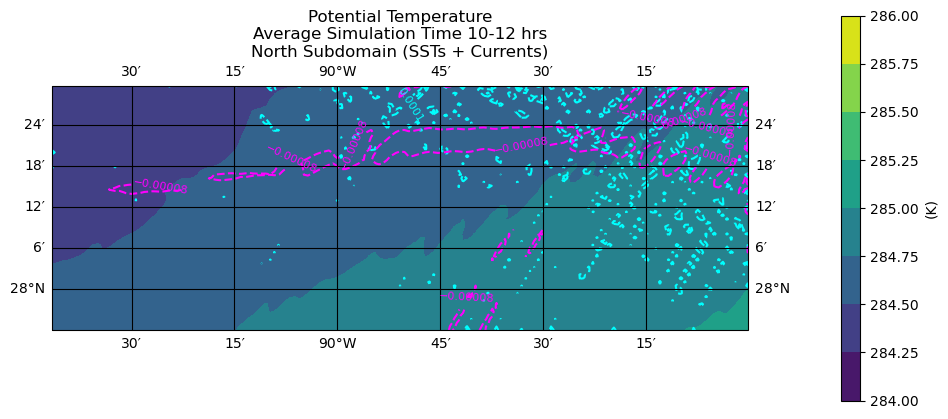

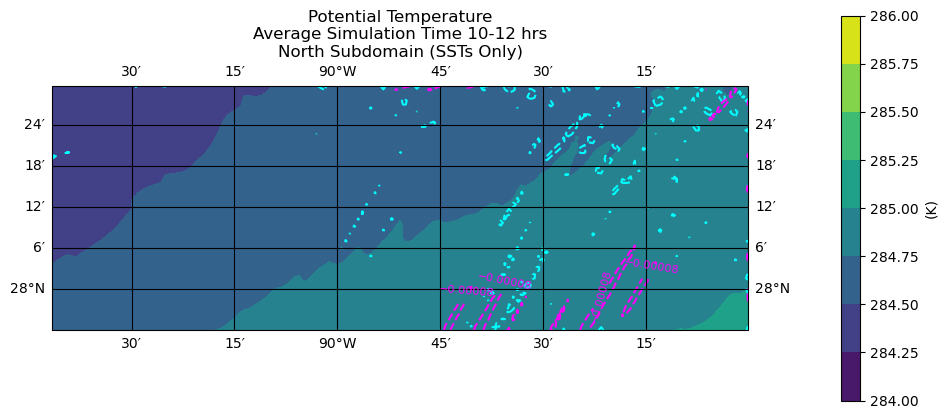

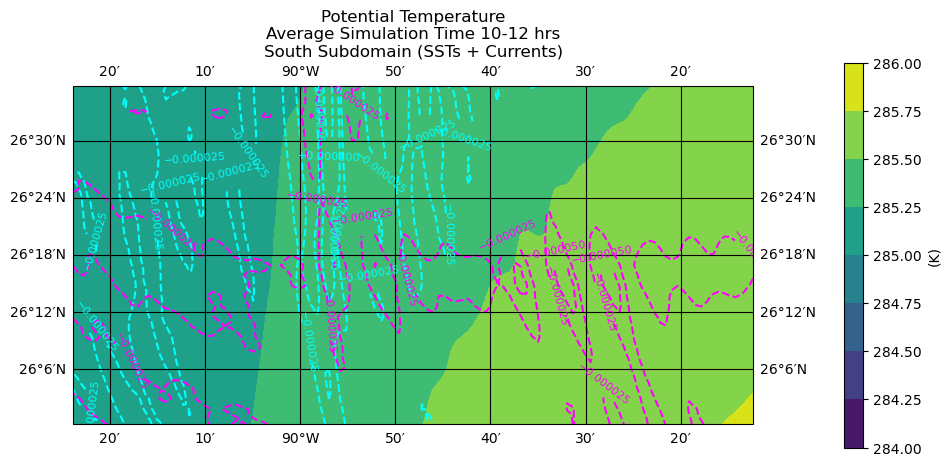

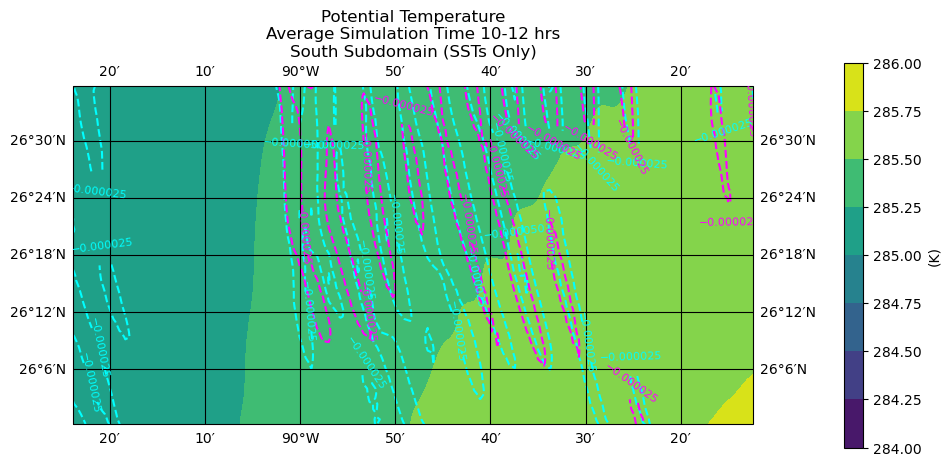

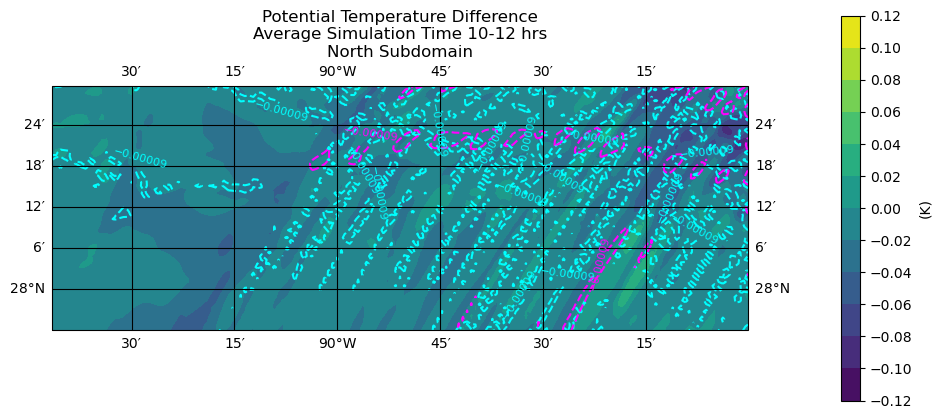

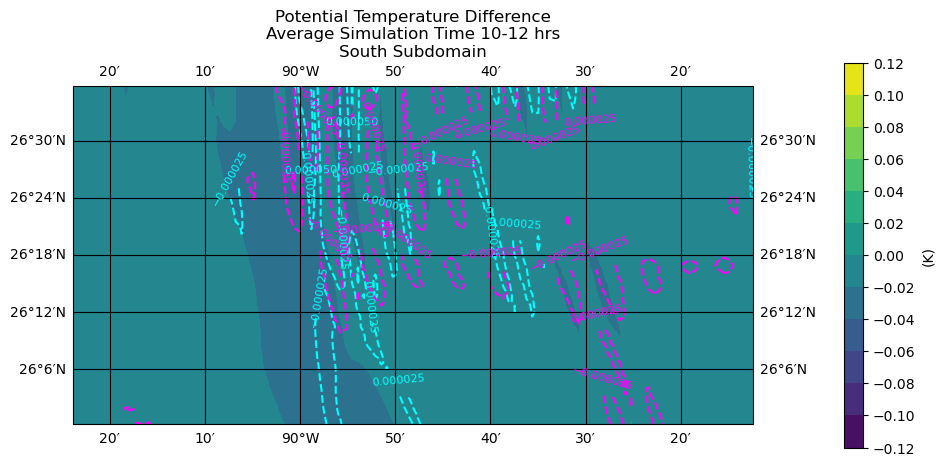

In [183]:
'''
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]

#vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

#vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
#diff_N
#vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]


#NORTH______________________________________________________________________________________
bounds = [284, 284.25, 284.5, 284.75, 285, 285.25, 285.5, 285.75, 286]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(north_lon, north_lat, north_cur_theta, levels = bounds)
#PBLH VORT
#cs1 = ax.contour(north_lon, north_lat, cur_curl_N_pblh, levels= vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
#ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature\nAverage Simulation Time 10-12 hrs\nNorth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'north_theta_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#_____________________________________________________________________________________
bounds = [284, 284.25, 284.5, 284.75, 285, 285.25, 285.5, 285.75, 286]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(north_lon, north_lat, north_sst_theta, levels = bounds)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, sst_curl_N_pblh, levels = vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature\nAverage Simulation Time 10-12 hrs\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'north_theta_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH____________________________________________________________________________
bounds = [284, 284.25, 284.5, 284.75, 285, 285.25, 285.5, 285.75, 286]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(south_lon, south_lat, south_cur_theta, levels= bounds)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, cur_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature\nAverage Simulation Time 10-12 hrs\nSouth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'south_theta_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#________________________________________________________________________________________________
bounds = [284, 284.25, 284.5, 284.75, 285, 285.25, 285.5, 285.75, 286]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(south_lon, south_lat, south_sst_theta, levels= bounds)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, sst_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature\nAverage Simulation Time 10-12 hrs\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'south_theta_sst.png', bbox_inches = 'tight',dpi = 150)

#North Diff _______________________________________________________________________________
bounds = [-0.12, -0.10, -0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(north_lon, north_lat, N_theta_diff, levels = bounds)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, N_pblh_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature Difference\nAverage Simulation Time 10-12 hrs\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'north_theta_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#South Diff_____________________________________________________________________________________
bounds = [-0.12, -0.10, -0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#THETA
cs = ax.contourf(south_lon, south_lat, S_theta_diff, levels = bounds)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, S_pblh_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(K)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Potential Temperature Difference\nAverage Simulation Time 10-12 hrs\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Theta/'
plt.savefig(save_results_to + 'south_theta_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()
'''

In [24]:
#get net surface radiation
#SHF
sst_shf10 = getvar(sst_wrfout10, 'HFX')
sst_shf11 = getvar(sst_wrfout11, 'HFX')
sst_shf12 = getvar(sst_wrfout12, 'HFX')
sst_shf13 = getvar(sst_wrfout13, 'HFX')

cur_shf10 = getvar(cur_wrfout10, 'HFX')
cur_shf11 = getvar(cur_wrfout11, 'HFX')
cur_shf12 = getvar(cur_wrfout12, 'HFX')
cur_shf13 = getvar(cur_wrfout13, 'HFX')

#LHF
sst_lhf10 = getvar(sst_wrfout10, 'LH')
sst_lhf11 = getvar(sst_wrfout11, 'LH')
sst_lhf12 = getvar(sst_wrfout12, 'LH')
sst_lhf13 = getvar(sst_wrfout13, 'LH')

cur_lhf10 = getvar(cur_wrfout10, 'LH')
cur_lhf11 = getvar(cur_wrfout11, 'LH')
cur_lhf12 = getvar(cur_wrfout12, 'LH')
cur_lhf13 = getvar(cur_wrfout13, 'LH')

#SW DOWN
sst_SWdown10 = getvar(sst_wrfout10, 'SWDOWN')
sst_SWdown11 = getvar(sst_wrfout11, 'SWDOWN')
sst_SWdown12 = getvar(sst_wrfout12, 'SWDOWN')
sst_SWdown13 = getvar(sst_wrfout13, 'SWDOWN')

cur_SWdown10 = getvar(cur_wrfout10, 'SWDOWN')
cur_SWdown11 = getvar(cur_wrfout11, 'SWDOWN')
cur_SWdown12 = getvar(cur_wrfout12, 'SWDOWN')
cur_SWdown13 = getvar(cur_wrfout13, 'SWDOWN')

#LW DOWN
sst_LWdown10 = getvar(sst_wrfout10, 'GLW')
sst_LWdown11 = getvar(sst_wrfout11, 'GLW')
sst_LWdown12 = getvar(sst_wrfout12, 'GLW')
sst_LWdown13 = getvar(sst_wrfout13, 'GLW')

cur_LWdown10 = getvar(cur_wrfout10, 'GLW')
cur_LWdown11 = getvar(cur_wrfout11, 'GLW')
cur_LWdown12 = getvar(cur_wrfout12, 'GLW')
cur_LWdown13 = getvar(cur_wrfout13, 'GLW')

#ALBEDO
sst_albedo10 = getvar(sst_wrfout10, 'ALBEDO')
sst_albedo11 = getvar(sst_wrfout11, 'ALBEDO')
sst_albedo12 = getvar(sst_wrfout12, 'ALBEDO')
sst_albedo13 = getvar(sst_wrfout13, 'ALBEDO')

cur_albedo10 = getvar(cur_wrfout10, 'ALBEDO')
cur_albedo11 = getvar(cur_wrfout11, 'ALBEDO')
cur_albedo12 = getvar(cur_wrfout12, 'ALBEDO')
cur_albedo13 = getvar(cur_wrfout13, 'ALBEDO')

#NEW
SB = 5.67*(10**8)
#surface net heat flux = SWdown  * (1 - SW albedo) + LW down - LW up  - LHF - SHF
LWup_sst10 = emis_sst10 * SB * skin_sst10**4
LWup_sst11 = emis_sst11 * SB * skin_sst11**4
LWup_sst12 = emis_sst12 * SB * skin_sst12**4
LWup_sst13 = emis_sst13 * SB * skin_sst13**4

LWup_cur10 = emis_sst10 * SB * skin_sst10**4
LWup_cur11 = emis_sst11 * SB * skin_sst11**4
LWup_cur12 = emis_sst12 * SB * skin_sst12**4
LWup_cur13 = emis_sst13 * SB * skin_sst13**4

new_sst_netRad10 = sst_SWdown10 * (1-sst_albedo10) + sst_LWdown10 - LWup_sst10 - sst_lhf10 - sst_shf10
new_sst_netRad11 = sst_SWdown12 * (1-sst_albedo11) + sst_LWdown11 - LWup_sst11 - sst_lhf11 - sst_shf11
new_sst_netRad12 = sst_SWdown13 * (1-sst_albedo12) + sst_LWdown12 - LWup_sst12 - sst_lhf12 - sst_shf12
new_sst_netRad13 = sst_SWdown13 * (1-sst_albedo13) + sst_LWdown13 - LWup_sst13 - sst_lhf13 - sst_shf13

new_cur_netRad10 = cur_SWdown10 * (1-cur_albedo10) + cur_LWdown10 - LWup_cur10  -cur_lhf10 - cur_shf10
new_cur_netRad11 = cur_SWdown11 * (1-cur_albedo11) + cur_LWdown11 - LWup_cur10  -cur_lhf11 - cur_shf11
new_cur_netRad12 = cur_SWdown12 * (1-cur_albedo12) + cur_LWdown12 - LWup_cur10  -cur_lhf12 - cur_shf12
new_cur_netRad13 = cur_SWdown13 * (1-cur_albedo13) + cur_LWdown13 - LWup_cur10  -cur_lhf13 - cur_shf13

#Averages:
new_cur_netRad_south = np.mean( np.array([ new_cur_netRad10, new_cur_netRad11, new_cur_netRad12 ]), axis=0 )
new_sst_netRad_south = np.mean( np.array([ new_sst_netRad10, new_sst_netRad11, new_sst_netRad12 ]), axis=0 )
new_cur_netRad_north = np.mean( np.array([ new_cur_netRad11, new_cur_netRad12, new_cur_netRad13 ]), axis=0 )
new_sst_netRad_north = np.mean( np.array([ new_sst_netRad11, new_sst_netRad12, new_sst_netRad13 ]), axis=0 )

#DIFF
diff_N = new_cur_netRad_north - new_sst_netRad_north
diff_S = new_cur_netRad_south - new_sst_netRad_south


In [25]:

LWup_sstS =np.mean( np.array([LWup_sst10, LWup_sst11, LWup_sst12 ]), axis=0 )
LWup_sstN =np.mean( np.array([LWup_sst11, LWup_sst12, LWup_sst13 ]), axis=0 )
LWup_curS =np.mean( np.array([LWup_cur10, LWup_cur11, LWup_cur12 ]), axis=0 )
LWup_curN =np.mean( np.array([LWup_cur11, LWup_cur12, LWup_cur13 ]), axis=0 )

LWdown_sstS = np.mean( np.array([sst_LWdown10, sst_LWdown11, sst_LWdown12 ]), axis=0 )
LWdown_sstN = np.mean( np.array([sst_LWdown11, sst_LWdown12, sst_LWdown13 ]), axis=0 )
LWdown_curS = np.mean( np.array([cur_LWdown10, cur_LWdown11, cur_LWdown12 ]), axis=0 )
LWdown_curN = np.mean( np.array([cur_LWdown11, cur_LWdown12, cur_LWdown13 ]), axis=0 )

netLW_sstN =LWdown_sstN-LWup_sstN
netLW_sstS =LWdown_sstS-LWup_sstS
netLW_curN =LWdown_curN-LWup_curN
netLW_curS =LWdown_curS-LWup_curS

#SWdown  * (1 - SW albedo)
sstSW10 = sst_SWdown10 * (1-sst_albedo10) 
sstSW11 = sst_SWdown11 * (1-sst_albedo11)
sstSW12 = sst_SWdown12 * (1-sst_albedo12) 
sstSW13 = sst_SWdown13 * (1-sst_albedo13)
#print(sstSW10 ) #0
#print(sstSW11 ) #0
#print(sstSW12 ) #0
#print(sstSW13 )

curSW10= cur_SWdown10 * (1-cur_albedo10)
curSW11= cur_SWdown11 * (1-cur_albedo11) 
curSW12= cur_SWdown12 * (1-cur_albedo12) 
curSW13= cur_SWdown13 * (1-cur_albedo13) 
#print(curSW10 ) #0
#print(curSW11 ) #0
#print(curSW12 ) #0
#print(curSW13 )

netSW_sstS =np.mean( np.array([sstSW10, sstSW11, sstSW12 ]), axis=0 )
netSW_sstN =np.mean( np.array([sstSW11, sstSW12, sstSW13 ]), axis=0 )
netSW_curS =np.mean( np.array([curSW10, curSW11, curSW12 ]), axis=0 )
netSW_curN =np.mean( np.array([curSW11, curSW12, curSW13 ]), axis=0 )

#print(netSW_sstS)
#print(netSW_curS)
#print(netSW_sstN)
#print(netSW_curN)

In [26]:

#Get net LW and net SW on domains 
netLW_Nsst = []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(netLW_sstN[y][x])
    netLW_Nsst.append(inner_arr)
netLW_Nsst = np.array(netLW_Nsst)

netLW_Ssst = []
for y in lat_int_south:
    inner_arr= []
    for x in lon_int_south:
        inner_arr.append(netLW_sstS[y][x])
    netLW_Ssst.append(inner_arr)
netLW_Ssst = np.array(netLW_Ssst)

netLW_Ncur = []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(netLW_curN[y][x])
    netLW_Ncur.append(inner_arr)
netLW_Ncur = np.array(netLW_Ncur)

netLW_Scur = []
for y in lat_int_south:
    inner_arr= []
    for x in lon_int_south:
        inner_arr.append(netLW_curS[y][x])
    netLW_Scur.append(inner_arr)
netLW_Scur = np.array(netLW_Scur)


netSW_Nsst = []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(netSW_sstN[y][x])
    netSW_Nsst.append(inner_arr)
    
netSW_Ssst = []
for y in lat_int_south:
    inner_arr= []
    for x in lon_int_south:
        inner_arr.append(netSW_sstS[y][x])
    netSW_Ssst.append(inner_arr)
netSW_Ssst = np.array(netSW_Ssst)

netSW_Ncur = []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(netSW_curN[y][x])
    netSW_Ncur.append(inner_arr)
netSW_Ncur = np.array(netSW_Ncur)

netSW_Scur = []
for y in lat_int_south:
    inner_arr= []
    for x in lon_int_south:
        inner_arr.append(netSW_curS[y][x])
    netSW_Scur.append(inner_arr)
netSW_Scur = np.array(netSW_Scur)

N_LW_DIFF =netLW_Ncur-netLW_Nsst
S_LW_DIFF = netLW_Scur-netLW_Ssst

In [17]:
'''
n_N = 11189
n_S = 7906

cur_lw_N_mean = np.nanmean(netLW_Ncur)
sst_lw_N_mean = np.nanmean(netLW_Nsst)
cur_lw_S_mean = np.nanmean(netLW_Scur)
sst_lw_S_mean = np.nanmean(netLW_Ssst)
print(' ')
print('cur_lw_N_mean : ', cur_lw_N_mean)
print('sst_lw_N_mean: ', sst_lw_N_mean)
print('cur_lw_S_mean: ', cur_lw_S_mean)
print('sst_lw_S_mean: ', sst_lw_S_mean)
cur_lw_N_std = np.nanstd(netLW_Ncur)
sst_lw_N_std = np.nanstd(netLW_Nsst)
cur_lw_S_std = np.nanstd(netLW_Scur)
sst_lw_S_std = np.nanstd(netLW_Ssst)
print(' ')
print('cur_lw_N_std: ', cur_lw_N_std)
print('sst_lw_N_std: ', sst_lw_N_std)
print('cur_lw_S_std: ', cur_lw_S_std)
print('sst_ls_S_std: ', sst_lw_S_std)
N_lw_diff = cur_lw_N_mean -sst_lw_N_mean 
S_lw_diff = cur_lw_S_mean -sst_lw_S_mean 
print(' ')
print('N_lw_diff: ', N_lw_diff)
print('S_lw_diff: ', S_lw_diff)
N_lw_diff_std = cur_lw_N_std -sst_lw_N_std 
S_lw_diff_std = cur_lw_S_std -sst_lw_S_std 
print(' ')
print('N_lw_diff_std: ', N_lw_diff_std)
print('S_lw_diff_std: ', S_lw_diff_std)
cur_lw_N_mean_unc = cur_lw_N_std /np.sqrt(n_N)
sst_lw_N_mean_unc =sst_lw_N_std /np.sqrt(n_N)
cur_lw_S_mean_unc =cur_lw_S_std /np.sqrt(n_S)
sst_lw_S_mean_unc =sst_lw_S_std /np.sqrt(n_S)
print(' ')
print('cur_lw_N_mean_unc : ', cur_lw_N_mean_unc)
print('sst_lw_N_mean_unc: ', sst_lw_N_mean_unc)
print('cur_lw_S_mean_unc: ', cur_lw_S_mean_unc)
print('sst_lw_S_mean_unc: ', sst_lw_S_mean_unc)
N_lw_diff_unc =np.sqrt( ((sst_lw_N_std**2)/n_N) + ((cur_lw_N_std**2)/n_N))
S_lw_diff_unc =np.sqrt( ((sst_lw_S_std**2)/n_S) + ((cur_lw_S_std**2)/n_S))
print(' ')
print('N_lw_diff_unc: ', N_lw_diff_unc)
print('S_lw_diff_unc: ', S_lw_diff_unc)
'''

 
cur_lw_N_mean :  378.36008
sst_lw_N_mean:  380.48102
cur_lw_S_mean:  349.06152
sst_lw_S_mean:  349.43332
 
cur_lw_N_std:  17.614553
sst_lw_N_std:  17.773722
cur_lw_S_std:  1.3165561
sst_ls_S_std:  1.3458644
 
N_lw_diff:  -2.1209412
S_lw_diff:  -0.37179565
 
N_lw_diff_std:  -0.15916824
S_lw_diff_std:  -0.02930832
 
cur_lw_N_mean_unc :  0.16652368042527832
sst_lw_N_mean_unc:  0.16802841807145727
cur_lw_S_mean_unc:  0.014806791580841186
sst_lw_S_mean_unc:  0.01513641078481596
 
N_lw_diff_unc:  0.23656645033050788
S_lw_diff_unc:  0.02117432427174861


In [21]:
'''
cur_sw_N_mean = np.nanmean(netSW_Ncur)
sst_sw_N_mean = np.nanmean(netSW_Nsst)
cur_sw_S_mean = np.nanmean(netSW_Scur)
sst_sw_S_mean = np.nanmean(netSW_Ssst)
print(' ')
print('cur_sw_N_mean : ', cur_sw_N_mean)
print('sst_sw_N_mean: ', sst_sw_N_mean)
print('cur_sw_S_mean: ', cur_sw_S_mean)
print('sst_sw_S_mean: ', sst_sw_S_mean)
cur_sw_N_std = np.nanstd(netSW_Ncur)
sst_sw_N_std = np.nanstd(netSW_Nsst)
cur_sw_S_std = np.nanstd(netSW_Scur)
sst_sw_S_std = np.nanstd(netSW_Ssst)
print(' ')
print('cur_sw_N_std: ', cur_sw_N_std)
print('sst_sw_N_std: ', sst_sw_N_std)
print('cur_sw_S_std: ', cur_sw_S_std)
print('sst_sw_S_std: ', sst_sw_S_std)
N_sw_diff = cur_sw_N_mean -sst_sw_N_mean 
S_sw_diff = cur_sw_S_mean -sst_sw_S_mean 
print(' ')
print('N_sw_diff: ', N_sw_diff)
print('S_sw_diff: ', S_sw_diff)
N_sw_diff_std = cur_sw_N_std -sst_sw_N_std 
S_sw_diff_std = cur_sw_S_std -sst_sw_S_std 
print(' ')
print('N_sw_diff_std: ', N_sw_diff_std)
print('S_sw_diff_std: ', S_sw_diff_std)
cur_sw_N_mean_unc = cur_sw_N_std /np.sqrt(n_N)
sst_sw_N_mean_unc =sst_sw_N_std /np.sqrt(n_N)
cur_sw_S_mean_unc =cur_sw_S_std /np.sqrt(n_S)
sst_sw_S_mean_unc =sst_sw_S_std /np.sqrt(n_S)
print(' ')
print('cur_sw_N_mean_unc : ', cur_sw_N_mean_unc)
print('sst_sw_N_mean_unc: ', sst_sw_N_mean_unc)
print('cur_sw_S_mean_unc: ', cur_sw_S_mean_unc)
print('sst_sw_S_mean_unc: ', sst_sw_S_mean_unc)
N_sw_diff_unc =np.sqrt( ((sst_sw_N_std**2)/n_N) + ((cur_sw_N_std**2)/n_N))
S_sw_diff_unc =np.sqrt( ((sst_sw_S_std**2)/n_S) + ((cur_sw_S_std**2)/n_S))
print(' ')
print('N_sw_diff_unc: ', N_sw_diff_unc)
print('S_sw_diff_unc: ', S_sw_diff_unc)
'''

 
cur_sw_N_mean :  21.498882
sst_sw_N_mean:  19.118858
cur_sw_S_mean:  0.0
sst_sw_S_mean:  0.0
 
cur_sw_N_std:  16.494085
sst_sw_N_std:  15.435397
cur_sw_S_std:  0.0
sst_sw_S_std:  0.0
 
N_sw_diff:  2.380024
S_sw_diff:  0.0
 
N_sw_diff_std:  1.0586882
S_sw_diff_std:  0.0
 
cur_sw_N_mean_unc :  0.15593104866047874
sst_sw_N_mean_unc:  0.14592246967852587
cur_sw_S_mean_unc:  0.0
sst_sw_S_mean_unc:  0.0
 
N_sw_diff_unc:  0.2135599660363264
S_sw_diff_unc:  0.0


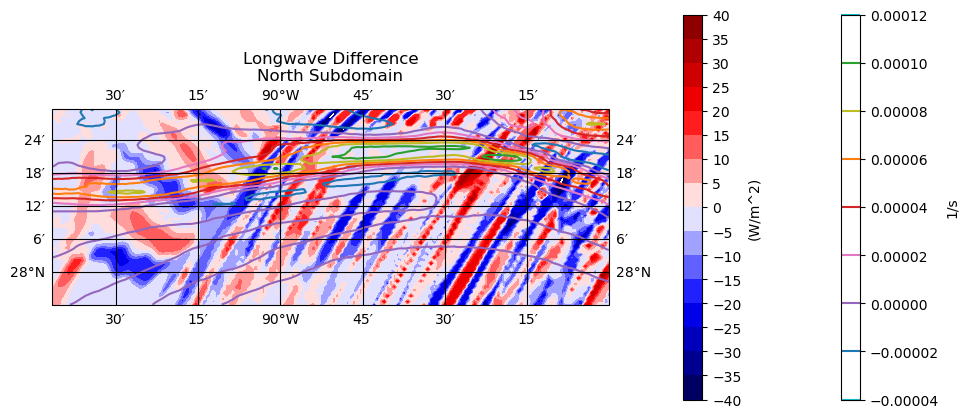

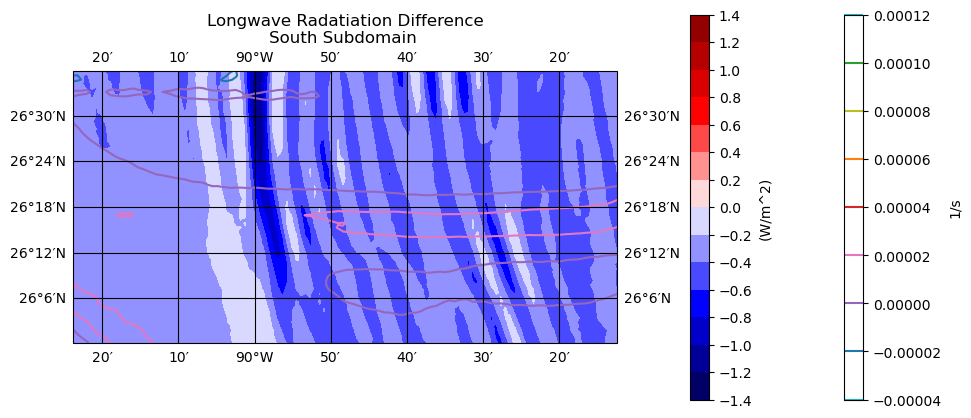

In [33]:
n_diff_bounds = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
s_diff_bounds = [-1.4, -1.2, -1.0, -0.8, -0.6,  -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(north_lon, north_lat, N_LW_DIFF, levels = n_diff_bounds , cmap = 'seismic' )
#cs = ax.contourf(north_lon, north_lat, N_lw_diff, levels = bounds)
PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = n_diff_bounds,  label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Longwave Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'north_LW_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
cs = ax.contourf(south_lon, south_lat, S_LW_DIFF, levels = s_diff_bounds , cmap = 'seismic' )
#cs = ax.contourf(south_lon, south_lat, S_LW_DIFF, levels = bounds)
PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, ticks = s_diff_bounds , pad = 0.1, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Longwave Radatiation Difference\nSouth Subdomain ')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'south_LW_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [9]:
#new domain netRad Diff
#Net Rad Diff 
netRad_Ndiff = []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(diff_N[y][x])
    netRad_Ndiff.append(inner_arr)
netRad_Ndiff = np.array(netRad_Ndiff)

netRad_Sdiff = []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(diff_S[y][x])
    netRad_Sdiff.append(inner_arr)
netRad_Sdiff = np.array(netRad_Sdiff)

#new domain netRad
netRad_cur_N= []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(new_cur_netRad_north[y][x])
    netRad_cur_N.append(inner_arr)
netRad_cur_N = np.array(netRad_cur_N)

netRad_cur_S= []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(new_cur_netRad_south[y][x])
    netRad_cur_S.append(inner_arr)
netRad_cur_S = np.array(netRad_cur_S)

netRad_sst_N= []
for y in lat_int_north:
    inner_arr= []
    for x in lon_int_north:
        inner_arr.append(new_sst_netRad_north[y][x])
    netRad_sst_N.append(inner_arr)
netRad_sst_N = np.array(netRad_sst_N)

netRad_sst_S= []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(new_sst_netRad_south[y][x])
    netRad_sst_S.append(inner_arr)
netRad_sst_S = np.array(netRad_sst_S)


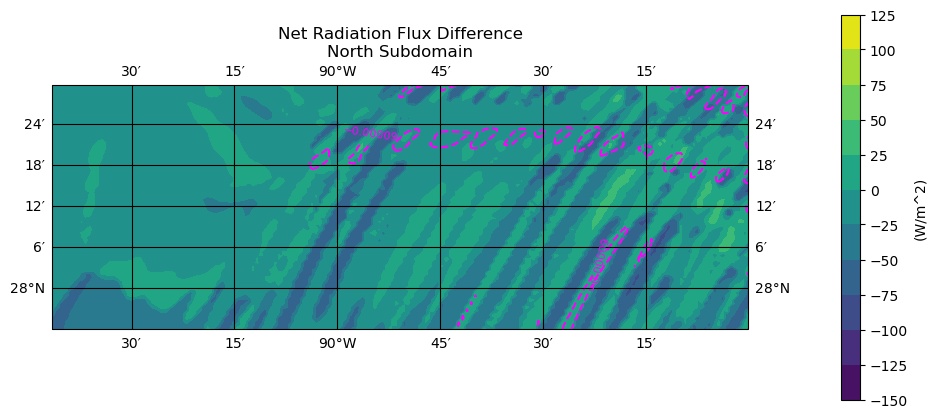

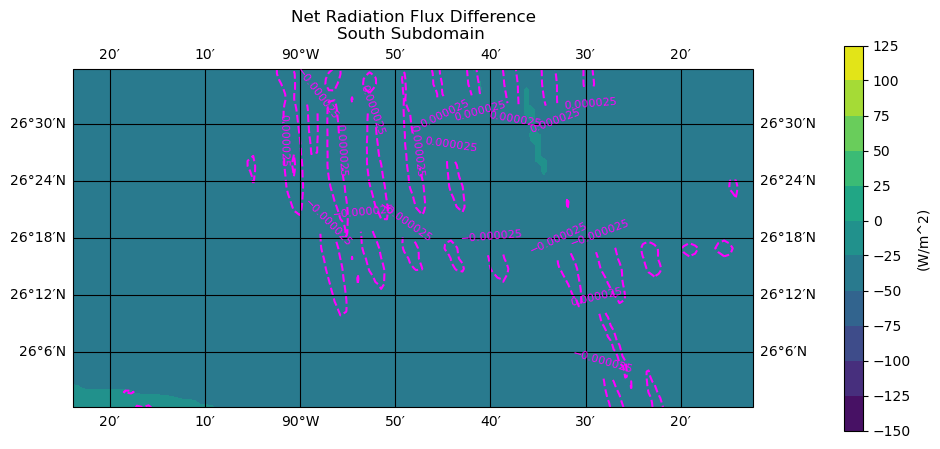

In [12]:
#DIFF PLOTS

vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]
vort_bounds_sfc_N = [-0.00016, -0.00008]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

bounds = [-150, -125, -100, -75, -50, -25, 0, 25, 50, 75, 100, 125]

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, netRad_Ndiff, levels = bounds)

#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'north_netrad_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, netRad_Sdiff, levels = bounds)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux Difference\nSouth Subdomain ')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'south_netrad_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

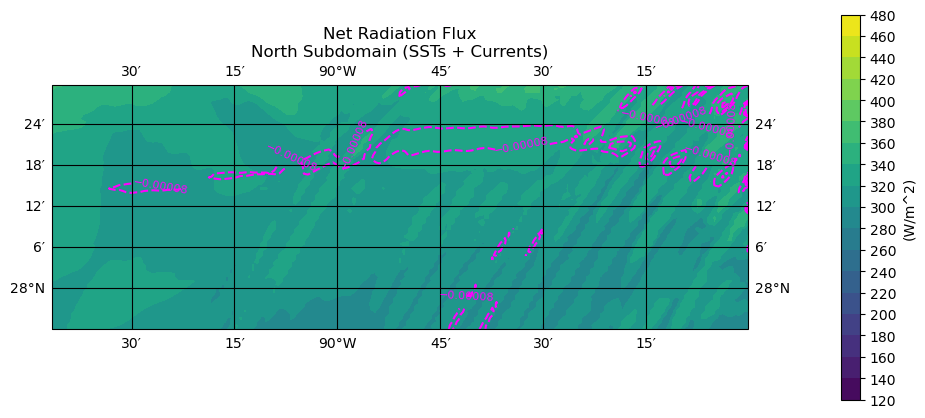

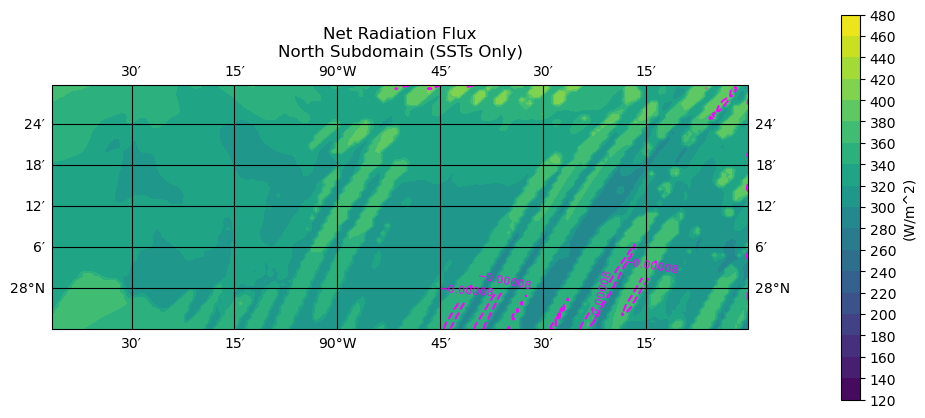

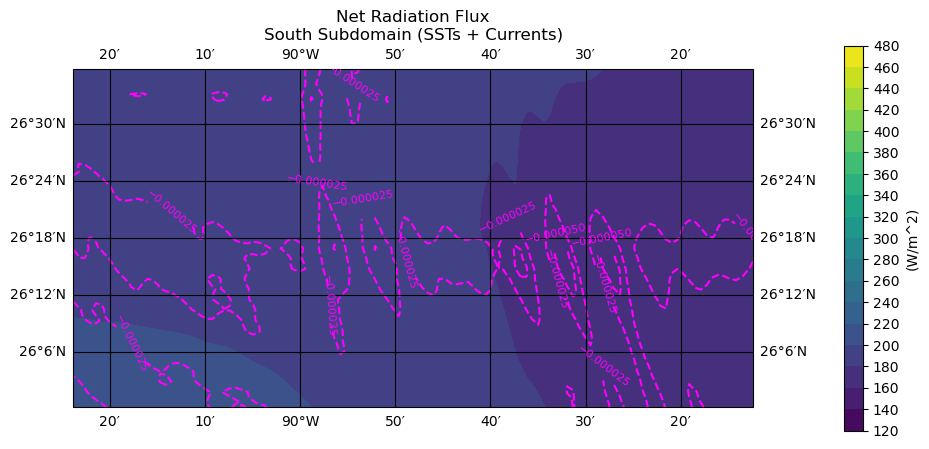

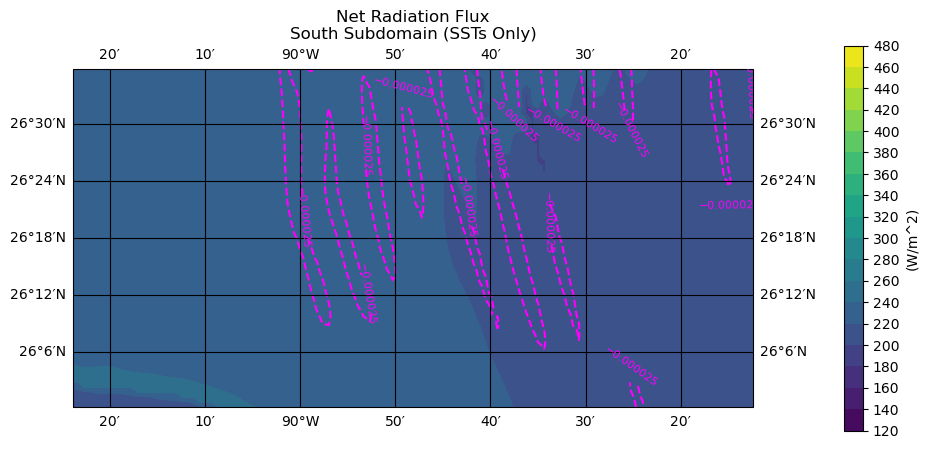

In [11]:
#NORTH NET RAD
vort_bounds_sfc_N = [ -0.00016, -0.00012, -0.00008]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

bounds = [120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480]

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, netRad_cur_N, levels = bounds)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux\nNorth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'north_netrad_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, netRad_sst_N, levels = bounds)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'north_netrad_sst.png', bbox_inches = 'tight',dpi = 150)


#SOUTH
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
cs = ax.contourf(south_lon, south_lat, netRad_cur_S, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux\nSouth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'south_netrad_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
cs = ax.contourf(south_lon, south_lat, netRad_sst_S, levels = bounds)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad = 0.1, ticks = bounds, label = '(W/m^2)')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Net Radiation Flux\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/NetRad/'
plt.savefig(save_results_to + 'south_netrad_sst.png', bbox_inches = 'tight',dpi = 150)